# Simulating NMR Spectra with xmris

In this tutorial, we will use the `xmris.processing.simulation` module to generate synthetic Free Induction Decay (FID) signals. Generating synthetic data is a critical step for validating fitting algorithms, building test suites, and understanding the physical parameters that govern magnetic resonance spectroscopy (MRS).

We will generate two distinct datasets with realistic parameters and physical noise:
1. A **1H (Proton)** spectrum showing the dominant water and lipid (fat) resonances.
2. A **13C (Carbon-13)** spectrum showing typical downstream metabolites of hyperpolarized [1-13C]pyruvate, utilizing carrier frequency offsets to prevent spectral aliasing.

## Theory: The AMARES Simulation Model

The signal generation in `xmris` is grounded in the AMARES (Advanced Method for Accurate, Robust, and Efficient Spectral fitting) algorithm, originally introduced by Vanhamme, van den Boogaart, and Van Huffel in 1997.



The time-domain magnetic resonance spectroscopy signal is modeled as a sum of exponentially damped sinusoids. The specific forward model used in our simulation function corresponds to Equation 6 of the AMARES paper:

$$y_n=\sum_{k=1}^{K}a_ke^{j\phi_k}e^{(-d_k(1-g_k+g_kt_n)t_n)}e^{j2\pi f_kt_n}$$

Where the parameters for each peak $k$ are defined as:
* **$a_k$**: The amplitude of the sinusoid.
* **$\phi_k$**: The phase.
* **$d_k$**: The damping factor, which determines the linewidth of the resonance.
* **$f_k$**: The frequency.
* **$g_k$**: The lineshape parameter, allowing the choice between a pure Lorentzian line form ($g_k=0$) or a pure Gaussian line form ($g_k=1$) for every peak separately.
* **$t_n$**: The time points of the sampled FID.

## 1. Environment Setup

First, let's import the necessary libraries. We will use `numpy` for array math, `xarray` for data structures, `matplotlib.pyplot` for figure management, and our updated `simulate_fid` function.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Import the simulation function from xmris
from xmris.processing.simulation import simulate_fid


## 2. Simulating a Noisy 1H (Proton) Spectrum

Proton spectroscopy in tissue is dominated by the massive water peak and the lipid backbone resonances. For this simulation, we assume a 3T clinical scanner (Larmor frequency ~127.7 MHz). We will also inject a realistic noise floor using our `target_snr` feature.

We will simulate the following resonances:

* **Water**: ~4.7 ppm (High amplitude, narrow linewidth)
* **Fat (Methylene CH2)**: ~1.3 ppm (Moderate amplitude, broader linewidth)
* **Fat (Methyl CH3)**: ~0.9 ppm (Low amplitude, broader linewidth)

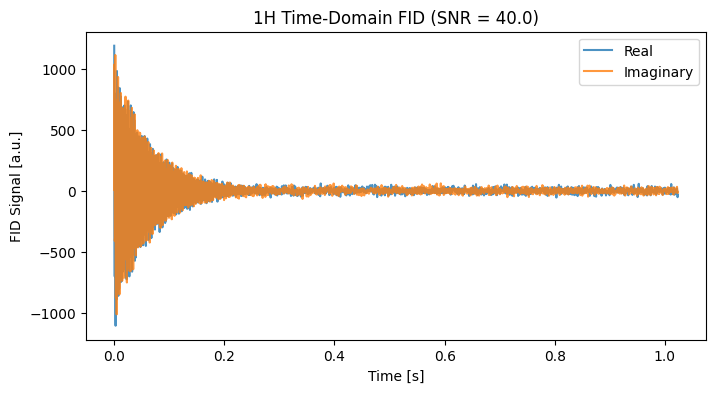

In [2]:
# --- 1H Simulation Parameters ---
b0_1h_mhz = 127.7
sw_1h = 2000.0
pts_1h = 2048
snr_1h = 40.0      # Target Signal-to-Noise Ratio

# Peak parameters
shifts_1h = [4.7, 1.3, 0.9]
amps_1h = [1000.0, 150.0, 50.0]
damps_1h = [15.0, 30.0, 30.0]
phases_1h = [0.0, 0.0, 0.0]
lineshapes_1h = [0.0, 0.2, 0.2]

# Generate the FID with complex Gaussian noise
fid_1h = simulate_fid(
    amplitudes=amps_1h,
    chemical_shifts=shifts_1h,
    reference_frequency=b0_1h_mhz,
    spectral_width=sw_1h,
    n_points=pts_1h,
    dampings=damps_1h,
    phases=phases_1h,
    lineshape_g=lineshapes_1h,
    target_snr=snr_1h
)

# Plotting the time-domain FID
fig, ax = plt.subplots(figsize=(8, 4))
fid_1h.real.plot(ax=ax, label='Real', alpha=0.8)
fid_1h.imag.plot(ax=ax, label='Imaginary', alpha=0.8)

ax.set_title(f"1H Time-Domain FID (SNR = {snr_1h})")
ax.legend()
plt.show()


To visualize the spectrum, we apply a Fast Fourier Transform (FFT). Because we simulated around a default carrier of 0 ppm, we construct the chemical shift axis directly from the FFT frequencies.

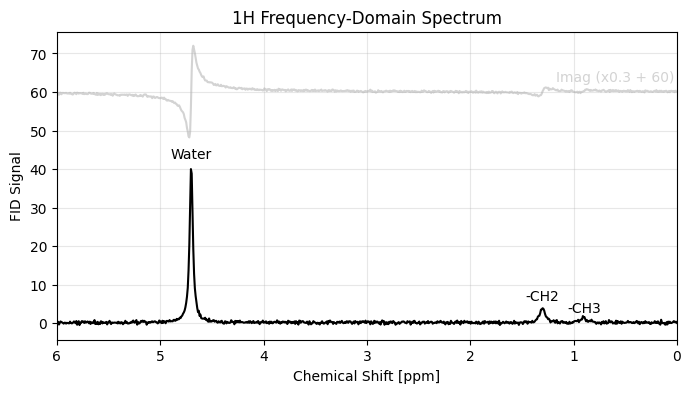

In [3]:
spec_1h = fid_1h.xmr.to_spectrum().xmr.to_ppm()

# Plot using xarray
fig, ax = plt.subplots(figsize=(8, 4))
normed_1h = spec_1h.real / np.max(spec_1h.real) * snr_1h
normed_1h.plot(ax=ax, color='black', x="chemical_shift")

normed_1h = spec_1h.imag / np.max(spec_1h.imag) * snr_1h * 0.3 + 60
normed_1h.plot(ax=ax, color='lightgray', x="chemical_shift", zorder=-10)

ax.set_xlim(6.0, 0.0)  # NMR convention: ppm decreases from left to right
ax.set_title("1H Frequency-Domain Spectrum")
ax.grid(True, alpha=0.3)
# Annotate peaks
ax.text(0.6, 62, "Imag (x0.3 + 60)", ha='center', va='bottom',  color='lightgray', fontsize=10)
ax.text(4.7, 42, "Water", ha='center', va='bottom', fontsize=10)
ax.text(1.3, 5.2, "-CH2", ha='center', va='bottom', fontsize=10)
ax.text(0.9, 2, "-CH3", ha='center', va='bottom', fontsize=10)

plt.show()


## 3. Simulating a 13C (Carbon-13) Spectrum with Carrier Offsets

Carbon-13 MRS spans a much wider chemical shift range. We will simulate the downstream metabolites of [1-13C]pyruvate. If we simulated this relative to 0 ppm, the massive frequency offsets would violate the Nyquist limit at standard sampling rates, causing the peaks to wrap (alias) to the wrong side of the spectrum.

To fix this, we set our `carrier_ppm` to 171.0 ppm, effectively centering the "listening window" of our digital receiver right over our metabolites.

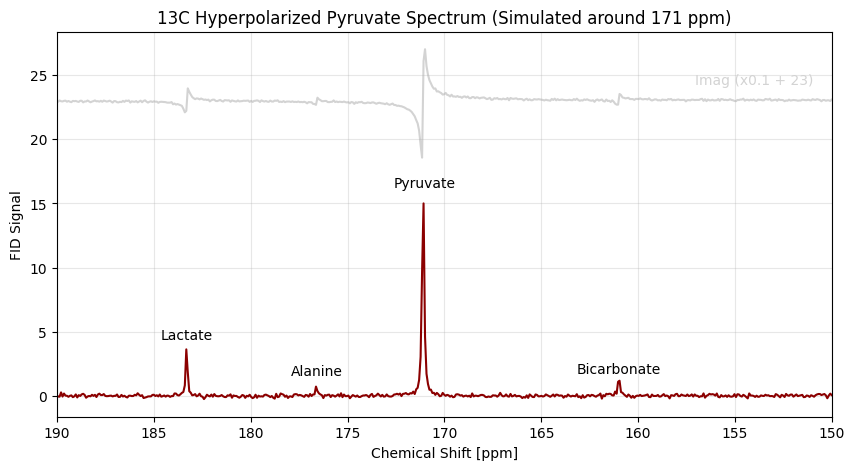

In [4]:
# --- 13C Simulation Parameters ---
b0_13c_mhz = 32.1
sw_13c = 5000.0    # Moderate spectral width is now sufficient due to the carrier shift
pts_13c = 2048
carrier_13c = 171.0 # Center the receiver on Pyruvate
snr_13c = 15.0      # Lower SNR typical of in vivo hyperpolarized experiments

shifts_13c = [183.3, 176.6, 171.1, 161.0]
amps_13c = [200.0, 50.0, 1000.0, 80.0]
damps_13c = [10.0, 10.0, 12.0, 10.0]
phases_13c = [0.0, 0.0, 0.0, 0.0]
lineshapes_13c = 0.0

# Generate the FID
fid_13c = simulate_fid(
    amplitudes=amps_13c,
    chemical_shifts=shifts_13c,
    reference_frequency=b0_13c_mhz,
    carrier_ppm=carrier_13c,
    spectral_width=sw_13c,
    n_points=pts_13c,
    dampings=damps_13c,
    phases=phases_13c,
    lineshape_g=lineshapes_13c,
    target_snr=snr_13c
)

# Calculate FFT
spec_13c = fid_13c.xmr.to_spectrum().xmr.to_ppm()

# Plot the Region of Interest
fig, ax = plt.subplots(figsize=(10, 5))
normed_13c = spec_13c.real / np.max(spec_13c.real) * snr_13c
normed_13c.plot(ax=ax, color='darkred', x="chemical_shift")

normed_13c = spec_13c.imag / np.max(spec_13c.imag) * snr_1h * 0.1 + 23
normed_13c.plot(ax=ax, color='lightgray', x="chemical_shift", zorder=-10)

ax.set_xlim(190, 150) # NMR convention: plot backwards
ax.set_title("13C Hyperpolarized Pyruvate Spectrum (Simulated around 171 ppm)")
ax.grid(True, alpha=0.3)

# Annotate peaks
ax.text(154, 24, "Imag (x0.1 + 23)", ha='center', va='bottom',  color='lightgray', fontsize=10)

ax.text(183.3, 4.2, "Lactate", ha='center', va='bottom', fontsize=10)
ax.text(176.6, 1.4, "Alanine", ha='center', va='bottom', fontsize=10)
ax.text(171, 16, "Pyruvate", ha='center', va='bottom', fontsize=10)
ax.text(161.0, 1.5, "Bicarbonate", ha='center', va='bottom', fontsize=10)

plt.show()
